# Explore I06S cruise data

In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean as cmocean

%matplotlib inline

### Load ancilliary data
We will use this data of bottom topography and climatological frontal locations for plotting.

In [262]:
data_dir ="/Users/dhruvbalwada/OneDrive/sogos_data/"
topo = xr.open_dataarray(
    data_dir+"data/processed/ETOPO1_Ice_g_gmt4_coarsened5.nc"
)

In [3]:
pf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/pf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
saf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/saf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
saccf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/saccf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
sbdy =  pd.read_csv(
    op.join(data_dir+"data/processed/fronts/sbdy.txt"),
    delim_whitespace=True,
    nrows=1079,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)

### Load I06S cruise data
 
Downloaded manually from (https://cchdo.ucsd.edu/cruise/325020190403) 

In [263]:
ctd_data_folder = data_dir + "data/raw/cruise/325020190403_nc_ctd/"
ctd_file_names = sorted(os.listdir(ctd_data_folder))

In [264]:
cruise_ctd = {}
for count, fil in enumerate(ctd_file_names):
    cruise_ctd[count] = xr.open_dataset(ctd_data_folder + fil)
    
# each cast from the ship is saved in a different file.
# A cast is a set of measurements made by the ship when it stops one location, 
# lowers instruments off the side, and measure variables. Often these casts are done from
# the surface of the ocean to the bottom. 

In [265]:
hyd_data_folder = data_dir + "data/raw/cruise/325020190403_nc_hyd/"
hyd_file_names = sorted(os.listdir(hyd_data_folder))

In [266]:
cruise_hyd = {}
for count, fil in enumerate(hyd_file_names):
    cruise_hyd[count] = xr.open_dataset(hyd_data_folder + fil)
    

### Load glider location data

In [267]:
glid_data_dir = '/Users/dhruvbalwada/work_root/glider-panel-demo/data/'

glid659_locs = xr.open_mfdataset(glid_data_dir+'659_locs.nc')
glid660_locs = xr.open_mfdataset(glid_data_dir+'660_locs.nc')

### Maps of cruise and other relevant properties

In [268]:
lat = [cruise_ctd[key].latitude.values[0] for key in cruise_ctd.keys()]
lon = [cruise_ctd[key].longitude.values[0] for key in cruise_ctd.keys()]
time = [cruise_ctd[key].time.values[0] for key in cruise_ctd.keys()]

len_pres = [len(cruise_ctd[key].pressure) for key in cruise_ctd.keys()]

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Text(0.5, 1.0, 'I06 2019 Cruise Track')

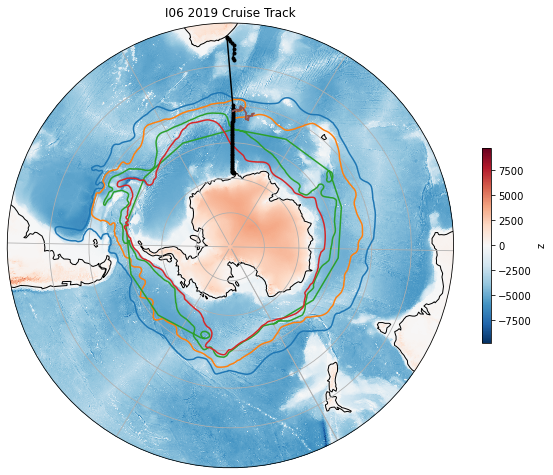

In [39]:
# Where was the cruise?
fig = plt.figure(figsize=(10, 9))
fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=29))
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

# make a circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Some decoration
ax.add_feature(cfeature.LAND)
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
ax.gridlines()

topo.sel(y=slice(-90, -30)).plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.4}
        )

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree())
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree())
plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree())

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k")

plt.plot(glid659_locs.longitude , glid659_locs.latitude, transform=ccrs.PlateCarree())
plt.plot(glid660_locs.longitude , glid660_locs.latitude, transform=ccrs.PlateCarree())

plt.title("I06 2019 Cruise Track")

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Text(0.5, 1.0, 'I06 2019 Cruise Track')

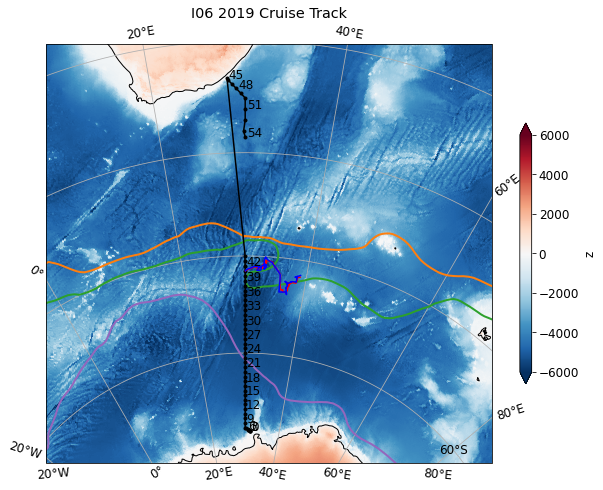

In [130]:
# Further Zoom in
fig = plt.figure(figsize=(10, 12))
fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=30))
ax.set_extent([10, 55, -70, -30], ccrs.PlateCarree())

# make a circular boundary

# Some decoration
ax.add_feature(cfeature.LAND)
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
ax.gridlines(draw_labels=True, ylocs=[-60,-50,-40,-30])

xsel = slice(-20, 80)
ysel = slice(-80, -30)
topo.sel(y=slice(-90, -10)).plot(
    vmin=-6000, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.4}
)

ax.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C1', label='SAF')
ax.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C2', label='PF')
#ax.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree(), linewidth=2, Marker=".", color='C3', label='SACCF')
ax.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C4', label='SBdy')

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k", label='I6S')


for i in range(0, len(lat), 3):
    ax.text(lon[i]+0.2, lat[i], i, transform=ccrs.PlateCarree(), color="k")

ax.plot(glid659_locs.longitude , glid659_locs.latitude, transform=ccrs.PlateCarree(), color='r', label='sg659')
ax.plot(glid660_locs.longitude , glid660_locs.latitude, transform=ccrs.PlateCarree(), color='b', label='sg660')

#ax.legend()

plt.title("I06 2019 Cruise Track")

### Calculate and convert data for plotting

In [269]:
# Calculate some Gibbs Sea Water (GSW) variables
# There are some oceanographic variables (SA, CT and sigma0) that are not measured directly,
# but are instead estimated using a package called gsw. 
cruise_ctd[33]['oxygen'] = np.NaN*cruise_ctd[33].oxygen # this cast had noisy O2
for i in cruise_ctd.keys():
    cruise_ctd[i] = xr.merge(
        [
            cruise_ctd[i],
            xr.DataArray(
                gsw.SA_from_SP(
                    cruise_ctd[i].salinity,
                    cruise_ctd[i].pressure,
                    cruise_ctd[i].longitude,
                    cruise_ctd[i].latitude,
                ).squeeze(),
                dims="pressure",
            ).rename("SA"),
        ]
    )

    cruise_ctd[i] = xr.merge(
        [
            cruise_ctd[i],
            xr.DataArray(
                gsw.CT_from_t(
                    cruise_ctd[i].SA,
                    cruise_ctd[i].temperature,
                    cruise_ctd[i].pressure
                ).squeeze(),
                dims="pressure",
            ).rename("CT"),
        ]
    )

    cruise_ctd[i] = xr.merge(
        [
            cruise_ctd[i],
            xr.DataArray(
                gsw.sigma0(cruise_ctd[i].SA,
                           cruise_ctd[i].CT).squeeze(), 
                dims="pressure"
            ).rename("sigma0"),
        ]
    )

    cruise_ctd[i] = xr.merge(
        [
            cruise_ctd[i],
            xr.DataArray(- cruise_ctd[i].oxygen + 
                gsw.O2sol(cruise_ctd[i].SA,
                          cruise_ctd[i].CT, 
                          cruise_ctd[i].pressure,
                          cruise_ctd[i].longitude,
                          cruise_ctd[i].latitude,
                        ).squeeze(), 
                dims="pressure"
            ).rename("AOU"),
        ]
    )    

In [311]:
cruise_ctd[1].oxygen

<xarray.DataArray 'oxygen' (pressure: 333)>
array([352.6633, 351.5134, 348.8461, ..., 210.914 , 212.1487, 211.202 ])
Coordinates:
  * pressure  (pressure) float64 0.0 2.0 4.0 6.0 8.0 ... 658.0 660.0 662.0 664.0
Attributes:
    long_name:           oxygen
    units:               ?mol/kg
    data_min:            198.1598
    data_max:            355.0242
    C_format:            %9.4f
    WHPO_Variable_Name:  CTDOXY
    OBS_QC_VARIABLE:     oxygen_QC

In [270]:
# Clean up back scatter data
from scipy.signal import medfilt
from scipy.ndimage import  minimum_filter1d, maximum_filter1d
for i in cruise_ctd.keys():
    cruise_ctd[i] = xr.merge(
        [
            cruise_ctd[i],
            xr.DataArray(
                maximum_filter1d(minimum_filter1d(cruise_ctd[i]
                        .CTDBACKSCATTER.where(cruise_ctd[i].CTDBACKSCATTER_QC == 1),5),5)
                 ,
                dims="pressure",
            ).rename("BBP_despiked_5"),
        ]
    )

In [271]:
# Each profile has its own pressure axis. Here we interpolate to a uniform pressure axis for plotting purpose
# The choices made here are arbitrary to some degree, and mostly for qualitative purposes. 

# find max pressure that is observed by any of the casts
max_pres = [cruise_ctd[key].pressure.max().values for key in cruise_ctd.keys()]
Pmax = max(max_pres)

Pint = np.linspace(0, Pmax, int(Pmax / 2) + 1) # interpolate to 2dbar grid

In [272]:
# Since different casts might make measurements at slightly different locations in depth, and also
# because there might be missing points (when QC - quality control - flag is not 2), we 
# interpolate the data to a uniform pressure grid.
# This is primarily for plotting purposes. 

Tint = np.stack(
    [
        cruise_ctd[key]
        .CT.where(cruise_ctd[key].temperature_QC != 4 )#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)
Sint = np.stack(
    [
        cruise_ctd[key]
        .SA.where(cruise_ctd[key].salinity_QC != 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)
sigma0int = np.stack(
    [
        cruise_ctd[key]
        .sigma0.where(cruise_ctd[key].salinity_QC!= 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)

OXYint = np.stack(
    [
        cruise_ctd[key]
        .oxygen.where(cruise_ctd[key].oxygen_QC != 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)
AOUint = np.stack(
    [
        cruise_ctd[key]
        .AOU.where(cruise_ctd[key].oxygen_QC != 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)
FLUORint = np.stack(
    [
        cruise_ctd[key]
        .CTDFLUOR.where(cruise_ctd[key].CTDFLUOR_QC != 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values - 0.0607 # subtract dark count values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)
BBPint = np.stack(
    [
        cruise_ctd[key]
        .BBP_despiked_5.where(cruise_ctd[key].CTDBACKSCATTER_QC != 4)#.where(cruise_ctd[key].oxygen_QC != 3)
        .interp(pressure=Pint)
        .values
        for key in cruise_ctd.keys()
    ],
    axis=0,
)

In [273]:
# now we convert these variables to an xarray dataset, since it makes it easier to plot. 
cruise_ds_int = xr.Dataset(
    {
        "temperature": (["cast_num", "pressure"], Tint),
        "salinity": (["cast_num", "pressure"], Sint),
        "oxygen": (["cast_num", "pressure"], OXYint),
        "AOU": (["cast_num", "pressure"], AOUint),
        "fluor": (["cast_num", "pressure"], FLUORint),
        "BBP": (["cast_num", "pressure"], BBPint),
        "sigma0": (["cast_num", "pressure"], sigma0int),
    },
    coords={
        "lon": (["cast_num"], lon),
        "lat": (["cast_num"], lat),
        "time": (["cast_num"], time),
        "pressure": (["pressure"], Pint),
    },
)

In [274]:
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


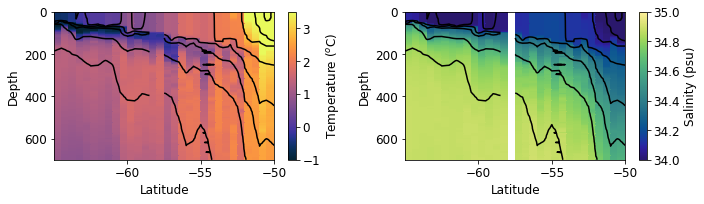

In [275]:
plt.figure(figsize=(10, 3))

n1 =14 
n2 = 45

plt.subplot(121)
plt.pcolormesh(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.temperature.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
               vmin=-1, vmax=3.5, cmap=cmocean.cm.thermal, rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Temperature ($^o$C)')
plt.contour(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.sigma0.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
                levels=7, colors='k')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.salinity.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
               vmin=34, vmax=35, cmap=cmocean.cm.haline, rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Salinity (psu)')
plt.contour(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.sigma0.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
                levels=7, colors='k')
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.tight_layout()
#plt.savefig('TSsigma_I6.pdf')

# note how the axis is changed here.

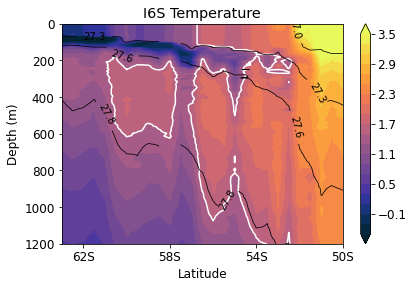

In [294]:

casts = slice(18,45)
pres = slice(0,1200)


plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.temperature.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=np.linspace(-0.5, 3.5,21),
            extend='both', cmap=cmocean.cm.thermal)
plt.gca().invert_yaxis()
cbar = plt.colorbar()#ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
#cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
#cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-62, -58, -54, -50, -46], labels=['62S', '58S', '54S', '50S', '46S'])

plt.contour(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.temperature.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=[1.5],
             colors = 'w')

CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=pres),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=pres).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-63,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Temperature')
plt.savefig('I6S_Temp.pdf')



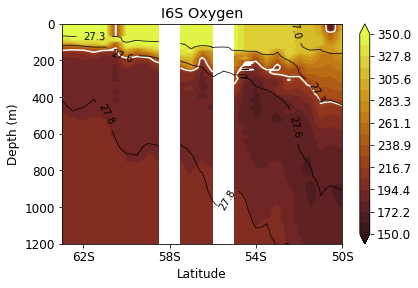

In [302]:

casts = slice(18,45)
pres = slice(0,1200)


plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.oxygen.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=np.linspace(150, 350,19),
            extend='both', cmap=cmocean.cm.solar)
plt.gca().invert_yaxis()
cbar = plt.colorbar()#ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
#cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
#cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-62, -58, -54, -50, -46], labels=['62S', '58S', '54S', '50S', '46S'])

plt.contour(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.oxygen.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=[220],
             colors='w')

CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=pres),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=pres).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-63,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Oxygen')
plt.savefig('I6S_Oxy.pdf')



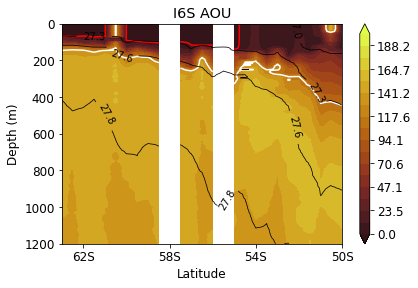

In [306]:

casts = slice(18,45)
pres = slice(0,1200)


plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.AOU.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=np.linspace(0, 200, 18),
            extend='both', cmap=cmocean.cm.solar)

plt.gca().invert_yaxis()
cbar = plt.colorbar()#ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
#cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
#cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-62, -58, -54, -50, -46], labels=['62S', '58S', '54S', '50S', '46S'])

plt.contour(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.oxygen.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=[220],
             colors='w')

plt.contour(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.AOU.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=[0],
             colors='r')

CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=pres),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=pres).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-63,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S AOU')
plt.savefig('I6S_AOU.pdf')



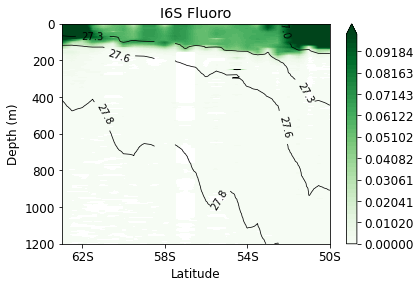

In [308]:

casts = slice(18,45)
pres = slice(0,1200)


plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.fluor.isel(cast_num=casts).sel(pressure=pres).T, # the division factor is for unit conversion
             levels=np.linspace(0, 1e-1),
            extend='max', cmap='Greens')
plt.gca().invert_yaxis()
cbar = plt.colorbar()#ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
#cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
#cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-62, -58, -54, -50, -46], labels=['62S','58S', '54S', '50S', '46S'])


CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=pres),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=pres).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-63,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Fluoro')
plt.savefig('I6S_Fluoro.pdf')



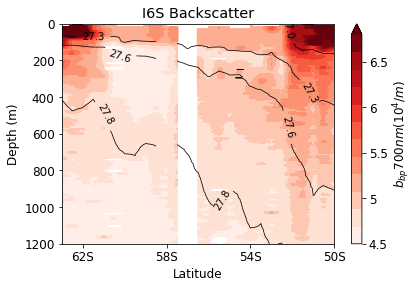

In [310]:

casts = slice(18,45)
pres = slice(0,1200)



plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=pres), 
             cruise_ds_int.BBP.isel(cast_num=casts).sel(pressure=pres).T/280, # the division factor is for unit conversion
             levels=np.linspace(4.5,6.8,13)*1e-4,
            extend='max', cmap='Reds')
plt.gca().invert_yaxis()
cbar = plt.colorbar(ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-62, -58, -54, -50, -46], labels=['62S','58S', '54S', '50S', '46S'])


CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=pres),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=pres).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-63,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Backscatter')
plt.savefig('I6S_backscatter.pdf')



In [86]:
# Sometimes oceanographers like to plot measurements on a temperature-salinity axis. 
# This is done because it provides insights into where the water might have come from, 
# or how well it is mixing, or if there are fronts present etc. 

# We can do this as follows:

# make a gridded density (Sigma0) for  plotting on TS plots
Tpts = np.linspace(-2, 5, 40)
Spts = np.linspace(33.8, 36, 41)
[Tg, Sg] = np.meshgrid(Tpts, Spts)
rhoTS = gsw.sigma0(Sg, Tg)

(-2.0, 4.0)

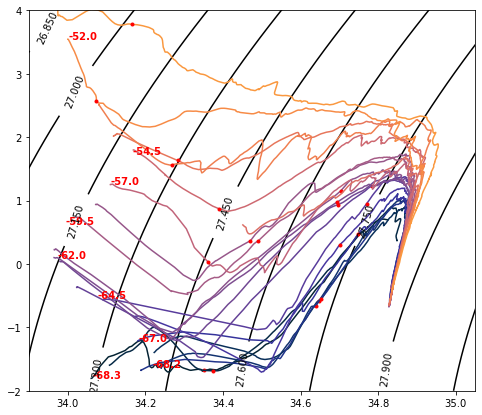

In [97]:
plt.figure(figsize=(8,7))
CS = plt.contour(Sg, Tg, rhoTS, levels=20, colors="k")
plt.clabel(CS,  inline=1, fontsize=10)

ncasts = len(cruise_ds_int.cast_num)
for n in range(0, 44, 2):
    plt.plot(
        cruise_ds_int.isel(cast_num=n).salinity.T,
        cruise_ds_int.isel(cast_num=n).temperature.T,
        color=cmocean.cm.thermal(n / ncasts),
    )
    plt.plot(
        cruise_ds_int.isel(cast_num=n).sel(pressure=150, method='nearest').salinity,
        cruise_ds_int.isel(cast_num=n).sel(pressure=150, method='nearest').temperature,
        color='r', marker='.'
    )

for n in range(0, 44, 5):
    plt.text(
        cruise_ds_int.isel(cast_num=n).salinity[10],
        cruise_ds_int.isel(cast_num=n).temperature[10],
        np.round(cruise_ds_int.isel(cast_num=n).lat.values, decimals=1),
        color="r", fontweight='bold'
    )

plt.xlim([33.9, 35.05])
plt.ylim([-2, 4])

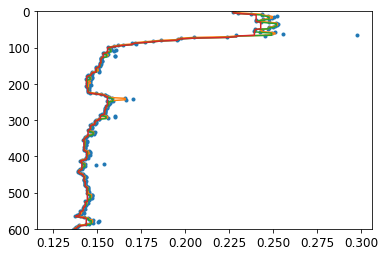

In [119]:
plt.plot(cruise_ctd[10].CTDBACKSCATTER, cruise_ctd[10].pressure, '.')
plt.plot(medfilt(cruise_ctd[10].CTDBACKSCATTER,5), cruise_ctd[10].pressure)
plt.plot(maximum_filter1d(minimum_filter1d(cruise_ctd[10].CTDBACKSCATTER,4),4), cruise_ctd[10].pressure)
plt.plot(maximum_filter1d(minimum_filter1d(cruise_ctd[10].CTDBACKSCATTER,10),10), cruise_ctd[10].pressure)
plt.ylim(0,600)

plt.gca().invert_yaxis()


Text(0.5, 1.0, 'I6S Backscatter')

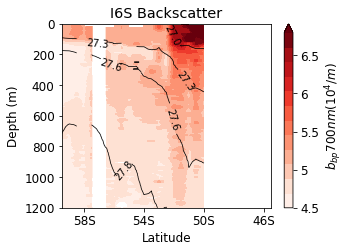

In [124]:
plt.figure(figsize=(5,3.5))
casts = slice(25,45)
plt.contourf(cruise_ds_int.lat.isel(cast_num=casts), 
             cruise_ds_int.pressure.sel(pressure=slice(0,1200)), 
             cruise_ds_int.BBP.isel(cast_num=casts).sel(pressure=slice(0,1200)).T/280, 
             levels=np.linspace(4.5,6.8,13)*1e-4,
            extend='max', cmap='Reds')
plt.gca().invert_yaxis()
cbar = plt.colorbar(ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
#plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])
plt.xticks([-58, -54, -50, -46], labels=['58S', '54S', '50S', '46S'])


CS = plt.contour(cruise_ds_int.lat.isel(cast_num=casts),
            cruise_ds_int.pressure.sel(pressure=slice(0,1200)),
            cruise_ds_int.sigma0.isel(cast_num=casts).sel(pressure=slice(0,1200)).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
plt.xlim(-59.5,-45.5)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Backscatter')
#plt.savefig('despiked_backscatter.pdf')